# Variational Autoencoders

https://pyro.ai/examples/vae.html

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as dset
import torchvision.transforms as transforms

import pyro
import pyro.distributions as dist
from pyro.optim import Adam
from pyro.infer import SVI, Trace_ELBO

from pathlib import Path

%matplotlib inline

data_home = Path('/home/danhojin/.torch/data')

## Data

In [2]:
# for loading and batching MNIST dataset
def setup_data_loaders(batch_size=128):
    download = True
    trans = transforms.Compose([
        transforms.ToTensor(),
        lambda x: x.reshape((-1,)),
    ])
    train_set = dset.MNIST(root=data_home, train=True, transform=trans,
                           download=download)
    test_set = dset.MNIST(root=data_home, train=False, transform=trans)

    kwargs = {'num_workers': 4}
    train_loader = torch.utils.data.DataLoader(dataset=train_set,
        batch_size=batch_size, shuffle=True, **kwargs)
    test_loader = torch.utils.data.DataLoader(dataset=test_set,
        batch_size=batch_size, shuffle=False, **kwargs)
    return train_loader, test_loader

In [3]:
train_loader, test_loader = setup_data_loaders(batch_size=256)

In [4]:
images, targets = next(iter(train_loader))

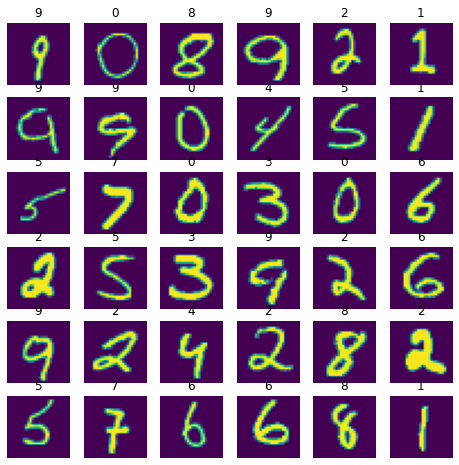

In [5]:
fig, axs = plt.subplots(6, 6, figsize=(8, 8))
axs = axs.flatten()
for k, ax in enumerate(axs):
    ax.imshow(images[k].reshape((28, 28)))
    ax.set_title(f'{targets[k]}')
    ax.axis('off')

## Encoder  P(z|x)

In [6]:
class Encoder(nn.Module):
    def __init__(self, z_dim, hidden_dim):
        super().__init__()
        self.fc1 = nn.Linear(784, hidden_dim)
        self.fc21 = nn.Linear(hidden_dim, z_dim)
        self.fc22 = nn.Linear(hidden_dim, z_dim)
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        z_loc = torch.tanh(self.fc21(x))
        z_scale = torch.exp(0.5 * torch.tanh(self.fc22(x)))
        return z_loc, z_scale

## Decoder  P(x|z)

In [7]:
class Decoder(nn.Module):
    def __init__(self, z_dim, hidden_dim):
        super().__init__()
        self.fc1 = nn.Linear(z_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, 784)
        
    def forward(self, z):
        x = torch.relu(self.fc1(z))
        x = torch.sigmoid(self.fc2(x))
        return x

## VAE

In [8]:
class VAE(nn.Module):
    def __init__(self, z_dim=10, hidden_dim=256):
        super().__init__()
        self.z_dim = z_dim
        
        self.encoder = Encoder(self.z_dim, hidden_dim)
        self.decoder = Decoder(self.z_dim, hidden_dim)
            
    def model(self, x):
        """
        p(x|z)p(z)
        """
        pyro.module('decoder', self.decoder)
        with pyro.plate('data', x.shape[0]):
            # setup variable structure
            z_loc = x.new_zeros((x.shape[0], self.z_dim))
            z_scale = x.new_ones((x.shape[0], self.z_dim))
            # obs
            z = pyro.sample('latent', dist.Normal(z_loc, z_scale).to_event(1))
            loc_img = self.decoder.forward(z)
            pyro.sample(
                'obs',
                dist.Bernoulli(loc_img).to_event(1),  # pixel-wise
                obs=x
            )
            
    def guide(self, x):
        """
        q(z|x)
        """
        pyro.module('encoder', self.encoder)
        with pyro.plate('data', x.shape[0]):
            z_loc, z_scale = self.encoder.forward(x)
            pyro.sample('latent', dist.Normal(z_loc, z_scale).to_event(1))
            
    def reconstruct_img(self, x):
        z_loc, z_scale = self.encoder(x)
        z = dist.Normal(z_loc, z_scale).sample()
        loc_img = self.decoder(z)
        return loc_img

In [9]:
def step(svi, loader, train=True, device=torch.device('cpu')):
    epoch_loss = 0.0
    for x, _ in loader:
        x = x.to(device)
        epoch_loss = svi.step(x) if train else svi.evaluate_loss(x)
        
    return epoch_loss / len(loader.dataset)

In [10]:
epochs = 100
device = torch.device('cuda')

train_loader, test_loader = setup_data_loaders(batch_size=256)

vae = VAE(z_dim=15)
vae.to(device)
optimizer = Adam({'lr': 1e-3})
svi = SVI(vae.model, vae.guide, optimizer, loss=Trace_ELBO())

for epoch in range(1, epochs + 1):
    epoch_loss = step(svi, train_loader, device=device)
    if epoch % 5 == 0:
        print(f'[epoch {epoch:03d}] average train loss: {epoch_loss:.4f}')
    if epoch % 20 == 0:
        epoch_loss = step(svi, test_loader, train=False, device=device)
        print(f' [epoch {epoch:03d}] average test loss: {epoch_loss:.4f}')

[epoch 005] average train loss: 0.2424
[epoch 010] average train loss: 0.2275
[epoch 015] average train loss: 0.2164
[epoch 020] average train loss: 0.2273
 [epoch 020] average test loss: 0.2143
[epoch 025] average train loss: 0.2357
[epoch 030] average train loss: 0.2180
[epoch 035] average train loss: 0.2245
[epoch 040] average train loss: 0.2199
 [epoch 040] average test loss: 0.2156
[epoch 045] average train loss: 0.2209
[epoch 050] average train loss: 0.2243
[epoch 055] average train loss: 0.2126
[epoch 060] average train loss: 0.2117
 [epoch 060] average test loss: 0.2120
[epoch 065] average train loss: 0.2273
[epoch 070] average train loss: 0.2155
[epoch 075] average train loss: 0.2127
[epoch 080] average train loss: 0.2257
 [epoch 080] average test loss: 0.2083
[epoch 085] average train loss: 0.2194
[epoch 090] average train loss: 0.2297
[epoch 095] average train loss: 0.2220
[epoch 100] average train loss: 0.2123
 [epoch 100] average test loss: 0.2217


## Reconstruct images

In [11]:
vae.cpu()
vae.eval()

VAE(
  (encoder): Encoder(
    (fc1): Linear(in_features=784, out_features=256, bias=True)
    (fc21): Linear(in_features=256, out_features=15, bias=True)
    (fc22): Linear(in_features=256, out_features=15, bias=True)
  )
  (decoder): Decoder(
    (fc1): Linear(in_features=15, out_features=256, bias=True)
    (fc2): Linear(in_features=256, out_features=784, bias=True)
  )
)

In [12]:
images, _ = next(iter(train_loader))

In [13]:
loc_images = vae.reconstruct_img(images)

images = images.numpy().reshape((-1, 28, 28))
loc_images = loc_images.detach().numpy().reshape((-1, 28, 28))

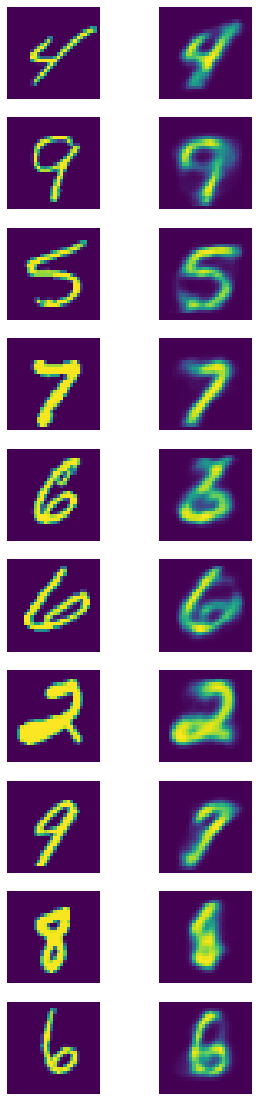

In [14]:
fig, axs = plt.subplots(10, 2, figsize=(5, 20))

for j, (ax0, ax1) in enumerate(axs):
    ax0.imshow(images[j].reshape((28, -1)))
    ax0.axis('off')
    ax1.imshow(loc_images[j].reshape((28, -1)))
    ax1.axis('off')

## TSNE

In [15]:
vae.eval()

test_z_loc = []
test_labels = []

for images, labels in test_loader:
    z_loc, _ = vae.encoder(images)
    for z, l in zip(z_loc.detach().numpy(), labels.numpy()):
        test_z_loc.append(z)
        test_labels.append(l)
        
test_labels = np.array(test_labels)

In [16]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=0)
z_embed = tsne.fit_transform(test_z_loc)

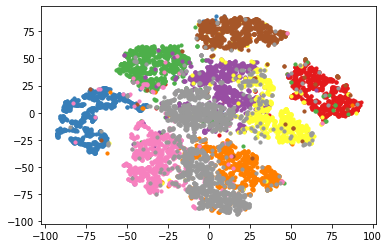

In [17]:
for ic in range(10):
    z = z_embed[test_labels == ic, :]
    plt.scatter(z[:, 0], z[:, 1], s=10, color=plt.cm.Set1(ic))